In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_classif,chi2
from sklearn.preprocessing import OrdinalEncoder,StandardScaler,LabelEncoder

In [2]:
df=pd.read_csv('sales.csv',index_col=[0])
df.shape

(400, 11)

In [3]:
df.head()

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,high
1,138,73,11,276,120,Bad,42,17,Yes,Yes,yes
2,111,48,16,260,83,Good,65,10,Yes,Yes,yes
3,113,35,10,269,80,Medium,59,12,Yes,Yes,yes
4,117,100,4,466,97,Medium,55,14,Yes,Yes,no
5,141,64,3,340,128,Bad,38,13,Yes,No,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 1 to 400
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CompPrice    400 non-null    int64 
 1   Income       400 non-null    int64 
 2   Advertising  400 non-null    int64 
 3   Population   400 non-null    int64 
 4   Price        400 non-null    int64 
 5   ShelveLoc    400 non-null    object
 6   Age          400 non-null    int64 
 7   Education    400 non-null    int64 
 8   Urban        400 non-null    object
 9   US           400 non-null    object
 10  high         400 non-null    object
dtypes: int64(7), object(4)
memory usage: 37.5+ KB


In [5]:
df.isnull().sum(),df.duplicated().sum()

(CompPrice      0
 Income         0
 Advertising    0
 Population     0
 Price          0
 ShelveLoc      0
 Age            0
 Education      0
 Urban          0
 US             0
 high           0
 dtype: int64,
 np.int64(0))

In [6]:
### outlier capping
def outlier_capping(df,columns):
    Q1= df[columns].quantile(0.25)
    Q3= df[columns].quantile(0.75)
    IQR= Q3-Q1
    lower_extreme= Q1-1.5*IQR
    upper_extreme= Q3+1.5*IQR
    df[columns]= df[columns].apply(lambda x: lower_extreme if x<lower_extreme else upper_extreme if x>upper_extreme else x)
for col in df.select_dtypes(include=['int','float']).columns:
    outlier_capping(df,col)

In [7]:
target = df[['high']]
features  =df.drop(columns=['high'])
target.high.unique()
target1 = target.copy()
lab_enc = LabelEncoder()

In [8]:
target1 = lab_enc.fit_transform(target1)
target1 = pd.DataFrame(target1,columns=target.columns)
target1.head()

,high
0,1
1,1
2,1
3,0
4,0


In [9]:
# train Test Split
x_train,x_test,y_train,y_test= train_test_split(features,target1,train_size=0.8,random_state=100,stratify=df.high)
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(320, 10) (80, 10) (320, 1) (80, 1)


In [13]:
x_train.head()

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
162,143.0,21,5,81,160.0,Medium,67,12,No,Yes
21,125.0,90,2,367,131.0,Medium,35,18,Yes,Yes
47,127.0,90,14,16,70.0,Medium,48,15,No,Yes
207,162.0,67,0,27,160.0,Medium,77,17,Yes,Yes
28,98.0,118,0,19,107.0,Medium,64,17,Yes,No


In [14]:
# Converting categorical columns into Numerical using Ordinal Encoder
ord_enc= OrdinalEncoder()
x_train[['ShelveLoc','Urban','US']]= ord_enc.fit_transform(x_train[['ShelveLoc','Urban','US']])
x_test[['ShelveLoc','Urban','US']]= ord_enc.transform(x_test[['ShelveLoc','Urban','US']])
x_train.head()

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
162,143.0,21,5,81,160.0,2.0,67,12,0.0,1.0
21,125.0,90,2,367,131.0,2.0,35,18,1.0,1.0
47,127.0,90,14,16,70.0,2.0,48,15,0.0,1.0
207,162.0,67,0,27,160.0,2.0,77,17,1.0,1.0
28,98.0,118,0,19,107.0,2.0,64,17,1.0,0.0


In [15]:
x_train.columns

Index(['CompPrice', 'Income', 'Advertising', 'Population', 'Price',
       'ShelveLoc', 'Age', 'Education', 'Urban', 'US'],
      dtype='object')

In [17]:
# Scaling numerical columns using Standard Scaler. This will convert the columns into same scale of range 0 to 1
std_sca= StandardScaler()
x_train[['CompPrice','Income','Price','Age']]= std_sca.fit_transform(x_train[['CompPrice','Income','Price','Age']])
x_test[['CompPrice','Income','Price','Age']]= std_sca.transform(x_test[['CompPrice','Income','Price','Age']])
x_train.head()

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
162,1.205960,-1.741724,5,81,1.857405,2.0,0.831738,12,0.0,1.0
21,0.029414,0.720802,2,367,0.625815,2.0,-1.164745,18,1.0,1.0
47,0.160141,0.720802,14,16,-1.964771,2.0,-0.353674,15,0.0,1.0
207,2.447869,-0.100040,0,27,1.857405,2.0,1.455639,17,1.0,1.0
28,-1.735405,1.720088,0,19,-0.393432,2.0,0.644568,17,1.0,0.0


<Axes: >

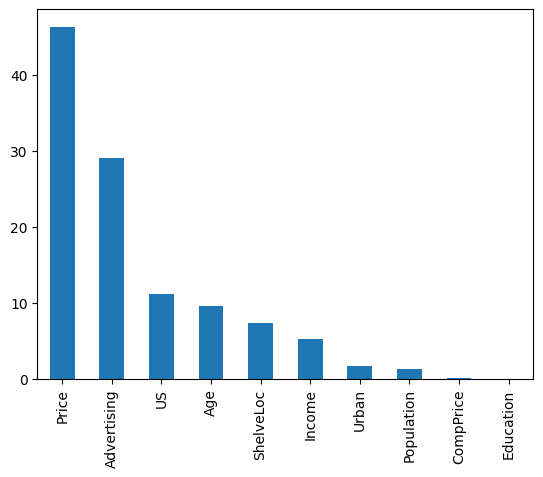

In [18]:
# Feature Selection
f_clas = f_classif(x_train,y_train)
pd.Series(f_clas[0],index=x_train.columns).sort_values(ascending=False).plot(kind='bar')

In [19]:
# Dropping less important features
x_train.drop(columns=['Education'],inplace=True)
x_test.drop(columns=['Education'],inplace=True)
x_train.head()

,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Urban,US
162,1.205960,-1.741724,5,81,1.857405,2.0,0.831738,0.0,1.0
21,0.029414,0.720802,2,367,0.625815,2.0,-1.164745,1.0,1.0
47,0.160141,0.720802,14,16,-1.964771,2.0,-0.353674,0.0,1.0
207,2.447869,-0.100040,0,27,1.857405,2.0,1.455639,1.0,1.0
28,-1.735405,1.720088,0,19,-0.393432,2.0,0.644568,1.0,0.0


In [20]:
# Model Training
dec_tree = DecisionTreeClassifier(criterion='gini',splitter='best',max_depth=4,random_state=50) # Here gini gives better accuracy than entropy
dec_tree.fit(x_train,y_train) # Fitting the model. That means training the model on train data or feeding the model with train data
y_pred = dec_tree.predict(x_test) # Predicting on test data
accuracy_score(y_test,y_pred) # Calculating the accuracy of the model

0.75

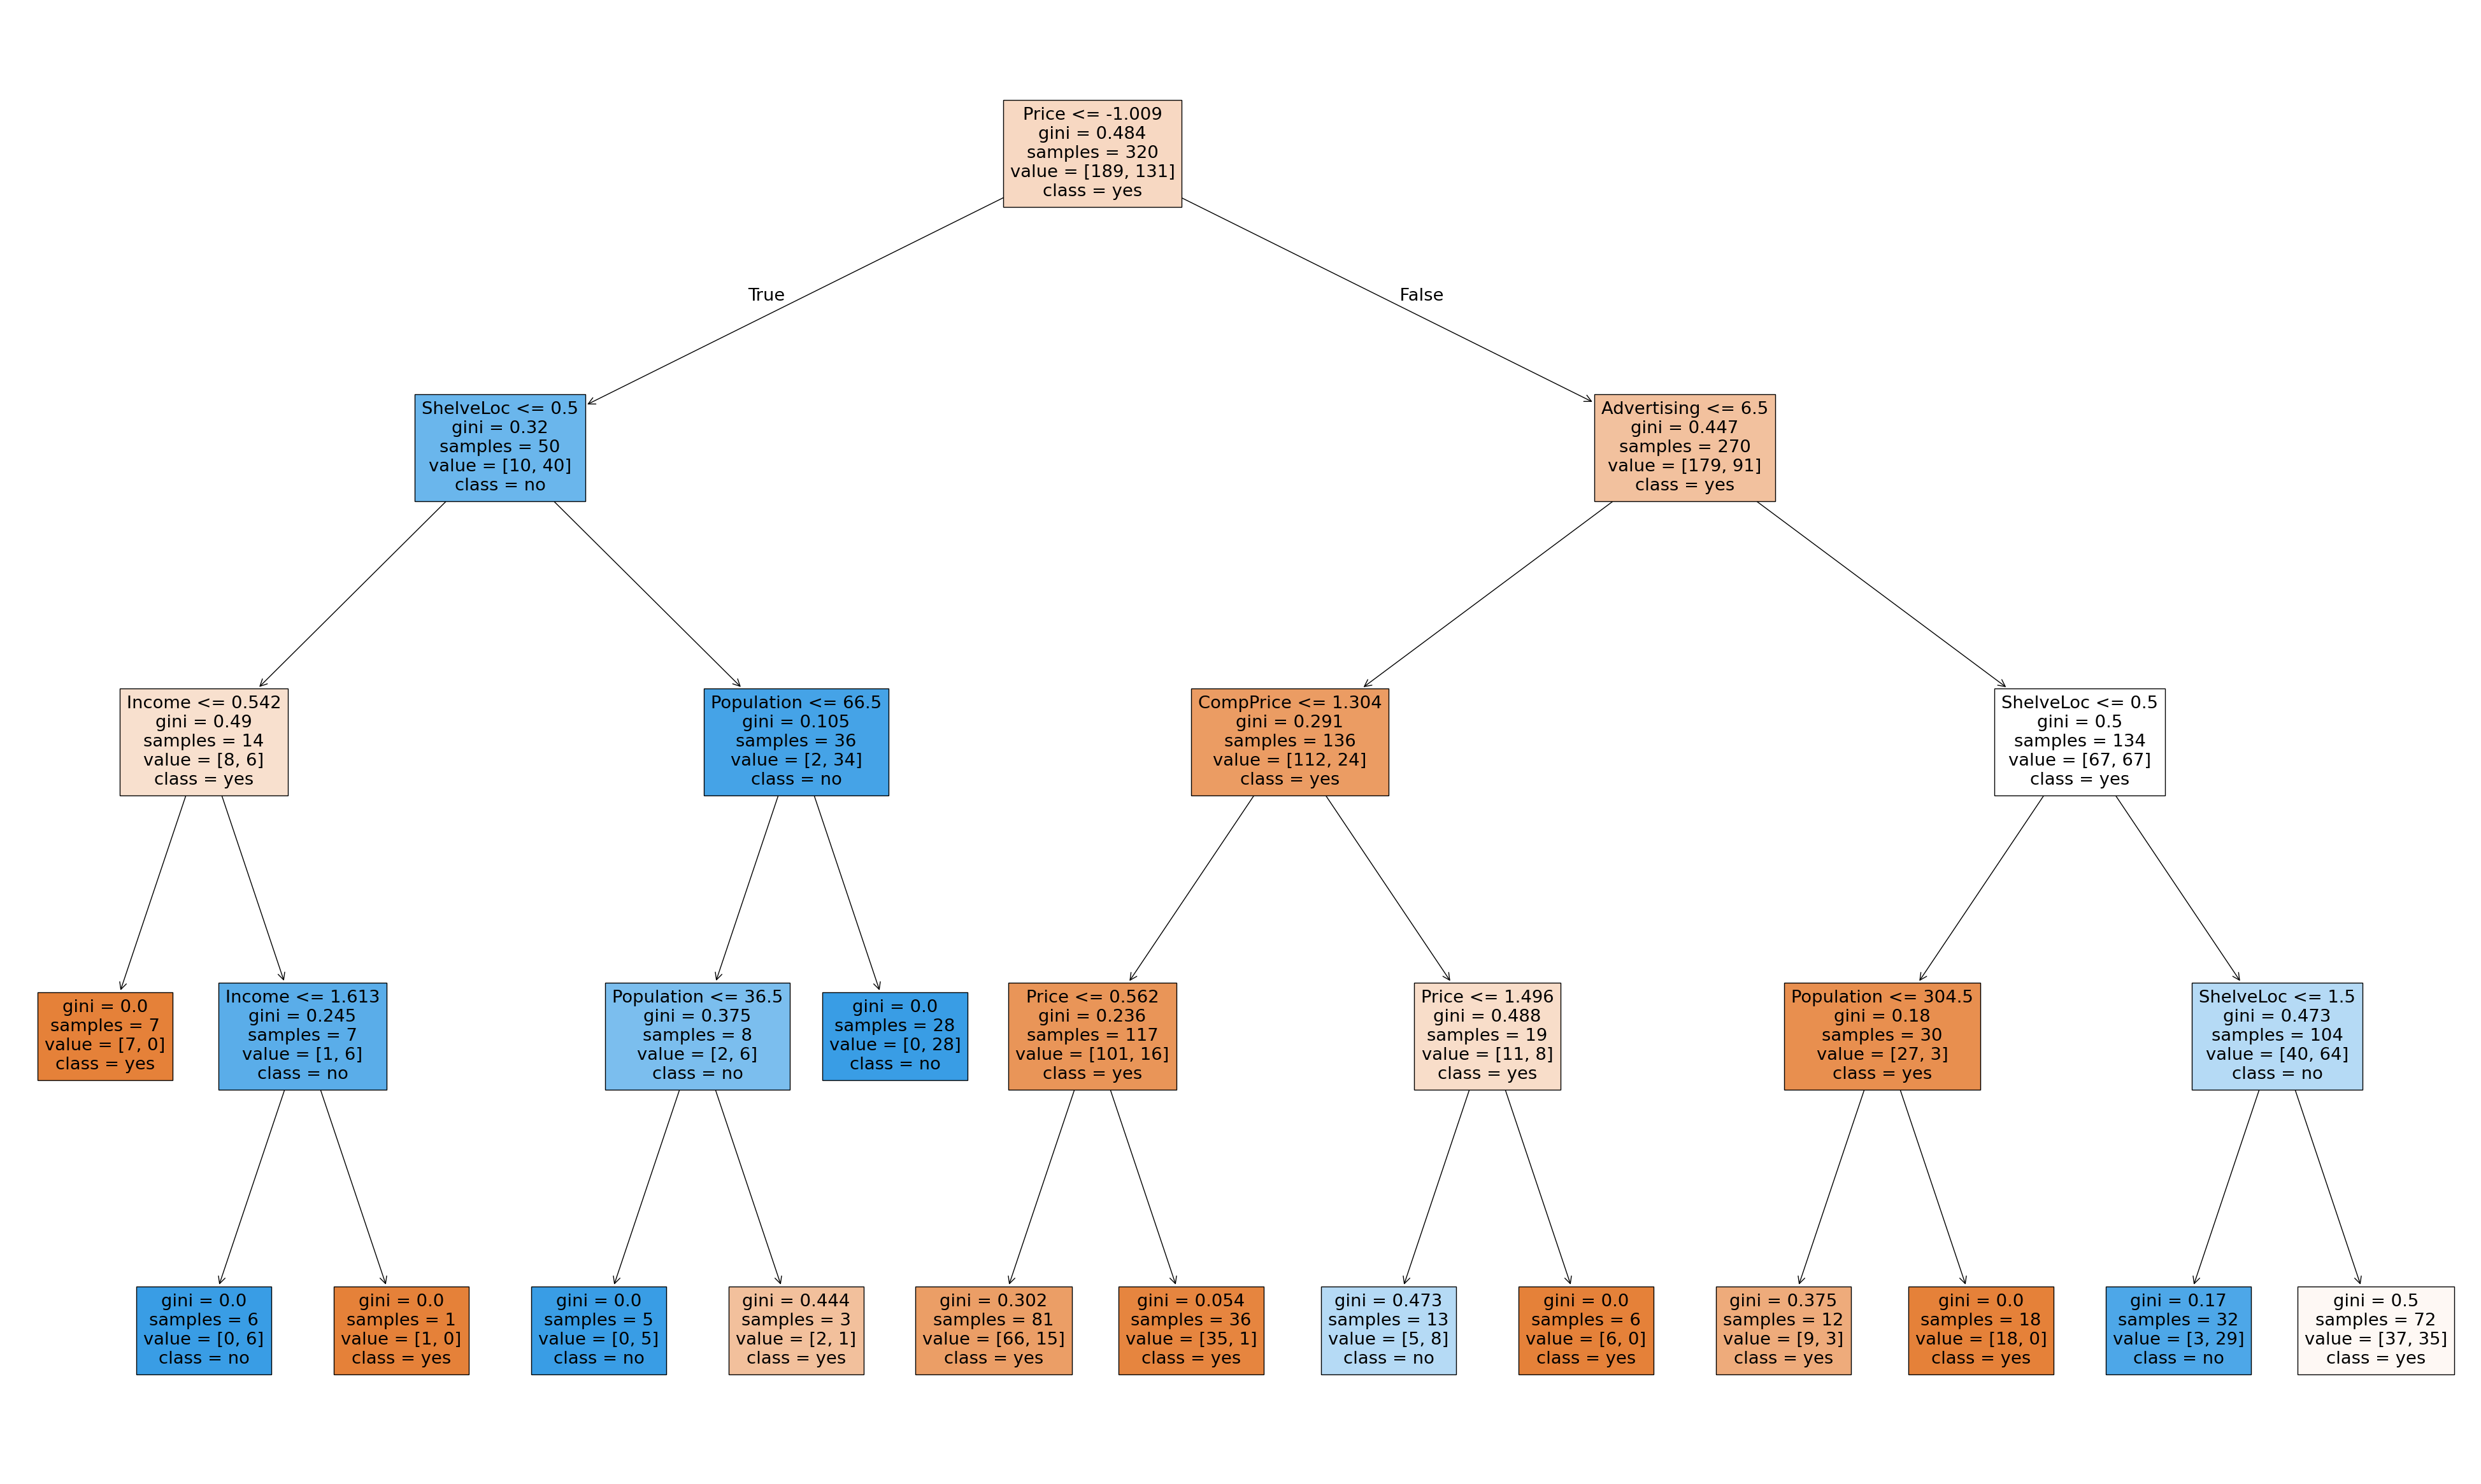

In [21]:
# Plotting the decision tree
plt.figure(figsize=(50,30))
plot_tree(dec_tree,filled=True,feature_names=list(features),class_names=target.high.unique());

In [22]:
#Grid Search
params = {'criterion':['gini','entropy'],'splitter':['best','random'],'max_depth':range(1,8)}
grid_search = GridSearchCV(estimator=dec_tree,param_grid=params,cv=5)


In [23]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=4, random_state=50),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 8),
                         'splitter': ['best', 'random']})

In [24]:
grid_search.best_params_,grid_search.best_score_

({'criterion': 'entropy', 'max_depth': 7, 'splitter': 'best'},
 np.float64(0.76875))

In [25]:
# Model Training
dec_tree = DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=7,random_state=50) # Here gini gives better accuracy than entropy
dec_tree.fit(x_train,y_train) # Fitting the model. That means training the model on train data or feeding the model with train data
y_pred = dec_tree.predict(x_test) # Predicting on test data
accuracy_score(y_test,y_pred) # Calculating the accuracy of the model

0.7

### Bagging (Bootstrap Aggregating)
Training many models and averaging them -> wisdom of the crowd


In [27]:
# Bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression


In [28]:
bag_class = BaggingClassifier(estimator=LogisticRegression(), n_estimators=200, bootstrap=True, bootstrap_features=True, 
                              max_features=0.7, max_samples=0.8, random_state=50)
bag_class.fit(x_train,y_train)
y_pred = bag_class.predict(x_test)
accuracy_score(y_test,y_pred)

0.7625

In [29]:
# GridSearch
params = {'n_estimators':[50,100,150,200],'max_features':[0.5,0.6,0.7,0.8]}
grid_search=GridSearchCV(estimator=bag_class,param_grid=params, cv=5)
grid_search.fit(x_train,y_train)
grid_search. best_params_, grid_search. best_score_

({'max_features': 0.8, 'n_estimators': 150}, np.float64(0.784375))

In [30]:
# Trains 150 Logistic Regression models using bagging, where each model learns from 80% randomly sampled rows and 80% 
# randomly sampled features (with replacement) to improve stability and accuracy.
bag_class = BaggingClassifier(estimator=LogisticRegression(), n_estimators=150, bootstrap=True, bootstrap_features=True, 
                              max_features=0.8, max_samples=0.8, random_state=50)
bag_class.fit(x_train,y_train)
y_pred = bag_class.predict(x_test)
accuracy_score(y_test,y_pred)

0.7875

### Random Forest (Bagging + Feature Randomness)
Random Forest = Bagging + Random Feature Selection.


At each split: Tree sees only a random subset of features.
Random Forest is one of the best bias–variance tradeoffs.

In [31]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rand_for = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=100, max_features='sqrt', max_samples=0.8)
rand_for.fit(x_train,y_train)
y_pred= rand_for.predict(x_test)
accuracy_score(y_test,y_pred)

0.775

In [32]:
# GridSearch
params = {'n_estimators':[50,100,150,200],'max_samples':[0.5,0.6,0.7,0.8]}
grid_search=GridSearchCV(estimator=rand_for,param_grid=params, cv=5)
grid_search.fit(x_train,y_train)
grid_search. best_params_, grid_search. best_score_

({'max_samples': 0.5, 'n_estimators': 200}, np.float64(0.825))

In [33]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rand_for = RandomForestClassifier(n_estimators=50, bootstrap=True, random_state=100, max_features=0.8, max_samples=0.5)
rand_for.fit(x_train,y_train)
y_pred= rand_for.predict(x_test)
accuracy_score(y_test,y_pred)

0.8

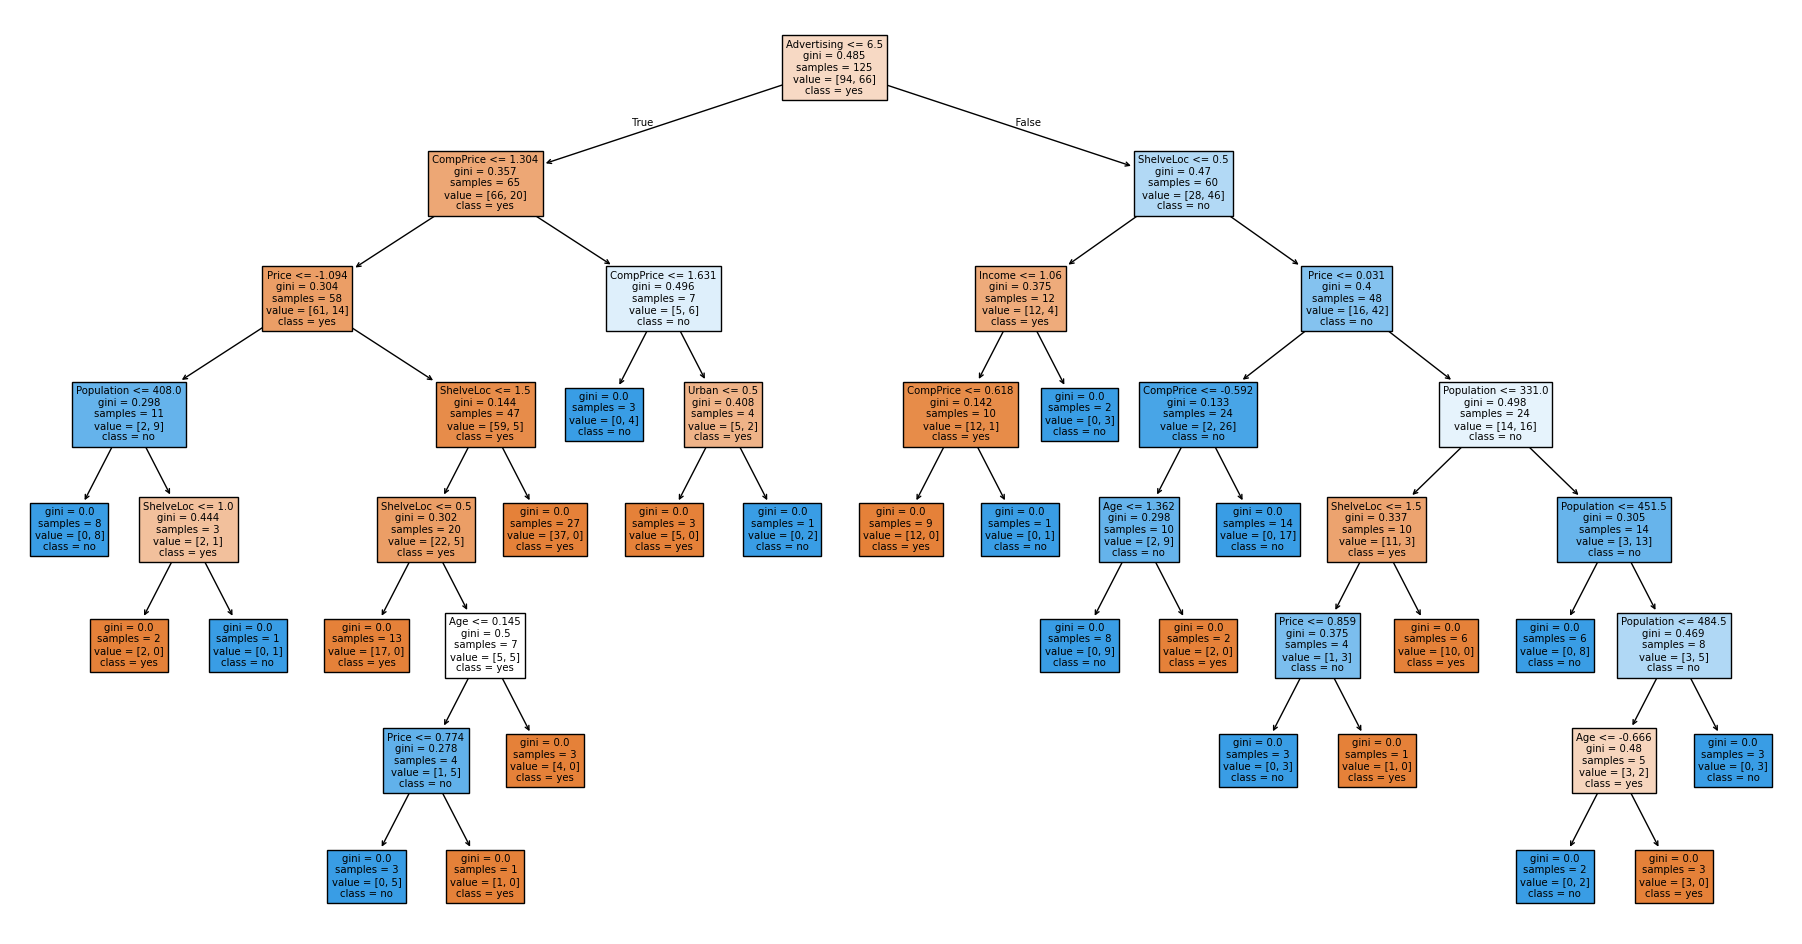

In [34]:
plt.figure(figsize=(23,12))
plot_tree(rand_for.estimators_[1],filled=True, feature_names=list(features), class_names=target.high.unique());